# Topik: Natural Language Processing (Klasifikasi Teks)

**Dataset:** 12.000 ulasan film dari **IMDB Reviews**, terbagi dalam 2 kelas (positif/negatif).
* 10000 Train data
* 2000 Test data
---

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import re
import string
import numpy as np
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Dense, Input, Dropout, Bidirectional, Embedding, LSTM, GRU
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import random
import os
import nltk
import gensim.downloader as api
import nlpaug.augmenter.word as naw

In [3]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [4]:
tfds.disable_progress_bar()

(raw_train, raw_test), metadata = tfds.load(
    'imdb_reviews',
    split=['train[:10000]', 'test[:2000]'],
    with_info=True,
    as_supervised=True,
)

print("Beberapa contoh ulasan dan labelnya:")
for text, label in raw_train.take(3):
    print(f"Label: {'Positif' if label.numpy() == 1 else 'Negatif'}")
    print(f"Ulasan: {text.numpy().decode('utf-8')[:100]}...\n")

BATCH_SIZE = 16
BUFFER_SIZE = 1000

train_dataset = raw_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = raw_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Training batches:", len(train_dataset))
print("Testing batches:", len(test_dataset))

Beberapa contoh ulasan dan labelnya:
Label: Negatif
Ulasan: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. ...

Label: Negatif
Ulasan: I have been known to fall asleep during films, but this is usually due to a combination of things in...

Label: Negatif
Ulasan: Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brenn...

Training batches: 625
Testing batches: 125


Jumlah data train  : 10000
Positif            : 5002
Negatif            : 4998
Panjang rata-rata review (kata) : 233.1


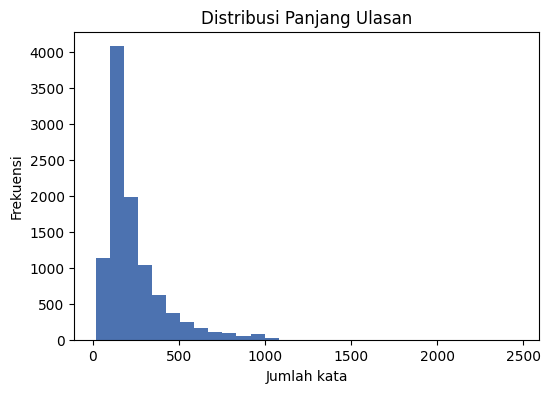

In [5]:
review_lengths = []
labels = []

for text_tensor, label_tensor in raw_train:
    labels.append(label_tensor.numpy())
    review_lengths.append(
        len(text_tensor.numpy().decode("utf-8").split())
    )

pos_count = int(np.sum(labels))
neg_count = len(labels) - pos_count

print(f"Jumlah data train  : {len(labels)}")
print(f"Positif            : {pos_count}")
print(f"Negatif            : {neg_count}")
print(f"Panjang rata-rata review (kata) : {np.mean(review_lengths):.1f}")

plt.figure(figsize=(6, 4))
plt.hist(review_lengths, bins=30, color="#4c72b0")
plt.title("Distribusi Panjang Ulasan")
plt.xlabel("Jumlah kata")
plt.ylabel("Frekuensi")
plt.show()

In [6]:
VOCAB_SIZE = 10000
SEQ_LEN = 200

vectorize_layer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LEN,
)

text_only_ds = raw_train.map(lambda txt, lbl: txt)
vectorize_layer.adapt(text_only_ds.batch(BATCH_SIZE))

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_ds = train_dataset.map(vectorize_text)
test_ds = test_dataset.map(vectorize_text)

# Bagi sebagian train menjadi validation
train_batches = len(train_ds)
val_batches = int(0.2 * train_batches)

val_ds = train_ds.take(val_batches)
train_ds_final = train_ds.skip(val_batches)

len(train_ds_final), len(val_ds)

(500, 125)

## Baseline

In [7]:
embedding_dim = 16
lstm_units    = 32

def create_baseline_model():
    inputs = layers.Input(shape=(SEQ_LEN,), dtype="int64")

    x = layers.Embedding(VOCAB_SIZE, embedding_dim)(inputs)
    x = layers.LSTM(lstm_units)(x)
    x = layers.Dense(16, activation="relu")(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs, name="baseline_lstm")

    return model

baseline_model = create_baseline_model()
baseline_model.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.Adam(0.0001),
    metrics=["accuracy"],
)

baseline_model.summary()

Model: "baseline_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,817 (651.63 KB)

 Trainable params: 166,817 (651.63 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = baseline_model.fit(
    train_ds_final,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.4997 - loss: 0.6932 - val_accuracy: 0.5065 - val_loss: 0.6931
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5180 - loss: 0.6928 - val_accuracy: 0.5325 - val_loss: 0.6925
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5633 - loss: 0.6854 - val_accuracy: 0.6265 - val_loss: 0.6515
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.7045 - loss: 0.6019 - val_accuracy: 0.7450 - val_loss: 0.5572
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.8149 - loss: 0.4537 - val_accuracy: 0.8015 - val_loss: 0.4691
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.8695 - loss: 0.3406 - val_accuracy: 0.8515 - val_loss: 0.3574
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9020 - loss: 0.2667 - val_accuracy: 0.8585 - val_loss: 0.3574
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9229 - loss: 0.2259 - 

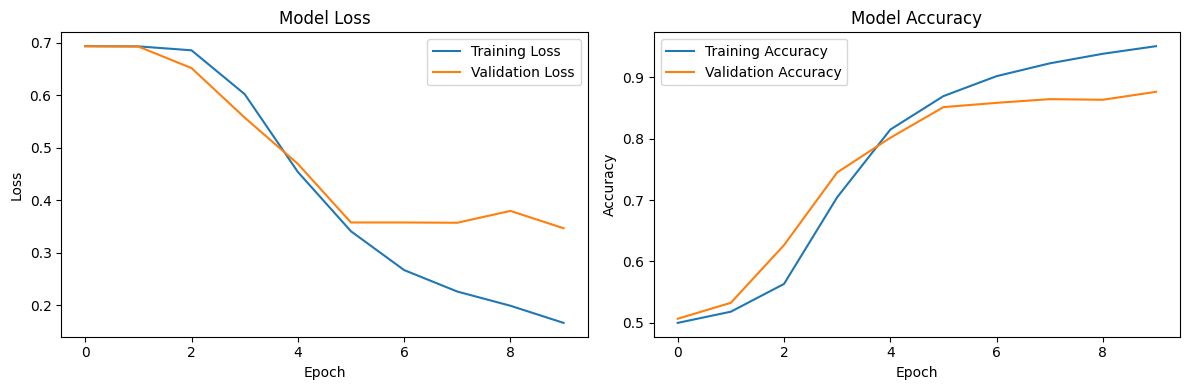


Baseline Model Final Results on Test Set:
Test Accuracy: 0.8140
Test Loss: 0.5270


In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate baseline model
baseline_test_loss, baseline_test_acc = baseline_model.evaluate(test_ds, verbose=0)
print(f"\nBaseline Model Final Results on Test Set:")
print(f"Test Accuracy: {baseline_test_acc:.4f}")
print(f"Test Loss: {baseline_test_loss:.4f}")

# Implementasi Solusi

## Modifikasi Baseline

In [ ]:
nltk_data_dir = os.path.join(os.path.expanduser("~"), "nltk_data")
if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)

nltk.data.path.append(nltk_data_dir)

nltk.download("wordnet", download_dir=nltk_data_dir)
nltk.download("omw-1.4", download_dir=nltk_data_dir)
nltk.download("averaged_perceptron_tagger", download_dir=nltk_data_dir)


[nltk_data] Downloading package wordnet to C:\Users\irfan\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\irfan\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\irfan\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
aug = naw.RandomWordAug(action="swap", aug_p=0.1)

aug_texts = []
aug_labels = []

val_size = 2000
raw_val = raw_train.take(val_size)
raw_train_small = raw_train.skip(val_size)

for text, label in raw_train_small.take(2000):
    text = text.numpy().decode("utf-8")
    aug_text = aug.augment(text)
    aug_texts.append(aug_text)
    aug_labels.append(int(label.numpy()))

# Buat dataset TF dari hasil augmentasi
aug_ds = tf.data.Dataset.from_tensor_slices((aug_texts, aug_labels))

# Samakan tipe dan shape
aug_ds = aug_ds.map(lambda x, y: (tf.reshape(x, ()), tf.cast(y, tf.int64)))

# Gabungkan dataset train-only dengan hasil augmentasi
raw_train_aug = raw_train_small.concatenate(aug_ds)

train_dataset = (raw_train_aug
                 .shuffle(BUFFER_SIZE)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))

test_dataset = (raw_test
                .batch(BATCH_SIZE)
                .prefetch(tf.data.AUTOTUNE))

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LEN,
)

# Adapt dengan dataset yang sudah di-augment
text_only_ds = raw_train_aug.map(lambda txt, lbl: txt)
vectorize_layer.adapt(text_only_ds.batch(BATCH_SIZE))

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_ds = train_dataset.map(vectorize_text)
test_ds = test_dataset.map(vectorize_text)

# === 4. Bagi train jadi train & validation ===
train_batches = len(train_ds)
val_batches = int(0.2 * train_batches)

val_ds = train_ds.take(val_batches)
train_ds_final = train_ds.skip(val_batches)

In [11]:
word2vec = api.load("word2vec-google-news-300") 

VOCAB_SIZE = len(vectorize_layer.get_vocabulary())
embedding_dim = 300
# Buat embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))
word_index = dict(zip(vectorize_layer.get_vocabulary(), range(VOCAB_SIZE)))

for word, i in word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]

In [12]:
model = Sequential([
    Input(shape=(SEQ_LEN,), dtype="int64"),
    Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=SEQ_LEN,
        trainable=False
    ),

    Bidirectional(LSTM(32, dropout=0.2)),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(0.0005),
    metrics=['accuracy']
)

model.summary()

C:\Users\irfan\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 300)       │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,102,145 (11.83 MB)

 Trainable params: 102,145 (399.00 KB)

 Non-trainable params: 3,000,000 (11.44 MB)

In [13]:
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, verbose=1
)

history_custom = model.fit(
    train_ds_final,
    validation_data=val_ds,
    epochs=100,
    verbose=1,
    callbacks=[early_stopper, lr_scheduler]
)

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.6235 - loss: 0.6359 - val_accuracy: 0.7710 - val_loss: 0.4998 - learning_rate: 5.0000e-04
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.7519 - loss: 0.5224 - val_accuracy: 0.7740 - val_loss: 0.4814 - learning_rate: 5.0000e-04
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.7738 - loss: 0.4820 - val_accuracy: 0.8110 - val_loss: 0.4424 - learning_rate: 5.0000e-04
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.7908 - loss: 0.4609 - val_accuracy: 0.8210 - val_loss: 0.4037 - learning_rate: 5.0000e-04
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.7778 - loss: 0.4685 - val_accuracy: 0.8205 - val_loss: 0.4131 - learning_rate: 5.0000e-04
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.8025 - loss: 0.4366 - val_accuracy: 0.8150 - val_loss: 0.4015 - learning_rate: 5.0000e-04
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 4

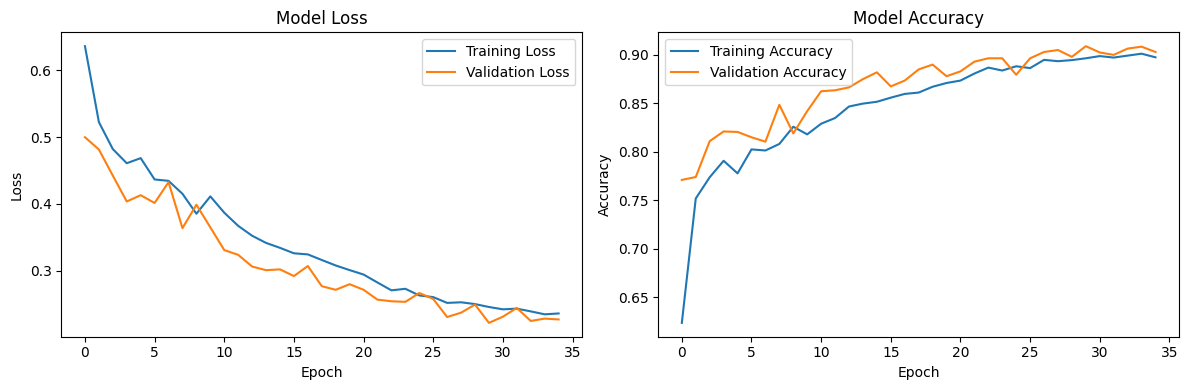

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_custom.history['loss'], label='Training Loss')
plt.plot(history_custom.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_custom.history['accuracy'], label='Training Accuracy')
plt.plot(history_custom.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
model_test_loss, model_test_acc = model.evaluate(test_ds, verbose=0)
print(f"\nModel Final Results on Test Set:")
print(f"Test Accuracy: {model_test_acc:.4f}")
print(f"Test Loss: {model_test_loss:.4f}")


Model Final Results on Test Set:
Test Accuracy: 0.8485
Test Loss: 0.3895


## Perbandingan Akhir

**Perbandingan Performa:**
- **Akurasi Model Baseline:** 81.4%
- **Akurasi Model Solusi:** `84.8%`